## **프로젝트: 뉴스기사 요약해보기**

In [38]:
# 필요한 라이브러리 import
import nltk
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

### **Step 1. 데이터 수집하기**

In [2]:
# 데이터 불러오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
# 데이터 확인
data.sample(10)

,headlines,text
97956,13 get life imprsionment over 2012 Maruti fact...,A Haryana Court on Saturday imprisoned 13 peop...
45659,"Man kicked off flight takes off shirt, attacks...",A passenger took off his shirt and attacked gr...
49839,Won't let forces lose morale: J&K Dy CM on FIR...,After an FIR was filed against jawans over the...
48976,India will become like US when Rajinikanth bec...,Filmmaker Ram Gopal Varma has said India will ...
88041,Museum of London to get see-through train tunnel,The Museum of London is planning a see-through...
4658,Censor Board raises objection to Thackeray bio...,The Censor Board has raised objection to scene...
62051,"Video shows fight between robots from Russia, ...",A video shows a fight between robots from Russ...
58931,India lifted over 130 million people out of po...,Speaking at the Global Entrepreneurship Summit...
7608,Amazon briefly becomes world's most valuable c...,World's richest person Jeff Bezos' Amazon brie...
96268,Man who killed black man in New York charged w...,"James Jackson, the 28-year-old who killed a bl..."


데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어 있다.  
* 추상적 요약: text를 본문, headlines를 이미 요약된 데이터로 사용
* 추출적 요약: text 열만을 사용

### **Step 2. 데이터 전처리하기 (추상적 요약)**

#### **중복 샘플과 NULL 값이 존재하는 샘플 제거**

In [4]:
# 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


데이터의 headlines는 아주 간단한 요약들도 많아서 text가 달라도 headlines는 동일할 수 있지만 text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야 한다.

In [5]:
# 중복 샘플 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


만약 Null 값을 가지는 샘플이 있었다면, 여전히 Null 값 한개가 어딘가 남아있을 수 있다.

In [6]:
# Null 값이 있는 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

#### **텍스트 정규화와 불용어 제거**

In [7]:
# 텍스트 정규화를 위한 사전 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재하는데, 이를 불용어(stopwords)라고 한다.  
NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거하도록 하자.

In [8]:
# 불용어 개수 확인
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

임의로 0번째 샘플을 지정하여 전처리 전과 후의 결과를 확인해보자.

In [10]:
temp_text = data['text'][0]
temp_headlines = data['headlines'][0]

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))

text:  saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
headlines: upgrad learner switches to career in ml al with salary hike


전처리 함수가 잘 작동하는 것을 확인했으므로, 이제 전체 훈련 데이터에 대해 전처리를 수행한다.  
text 열의 경우 불용어를 제거하고, headlines 열의 경우 불용어를 제거하지 않는다.

In [11]:
clean_text = []
# 전체 text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋다.

In [13]:
data['text'] = clean_text
data['healines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
# Null 값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
healines     0
dtype: int64

In [15]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### **샘플의 최대 길이 정하기**

텍스트의 최소 길이: 1
텍스트의 최대 길이: 60
텍스트의 평균 길이: 35.09968483123221
요약의 최소 길이: 1
요약의 최대 길이: 18
요약의 평균 길이: 9.553660024400163


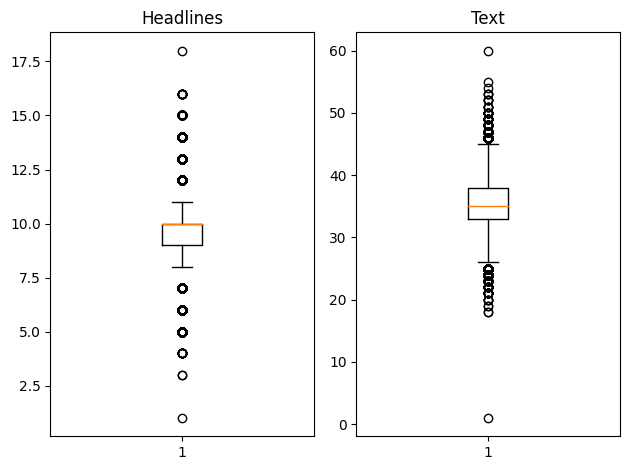

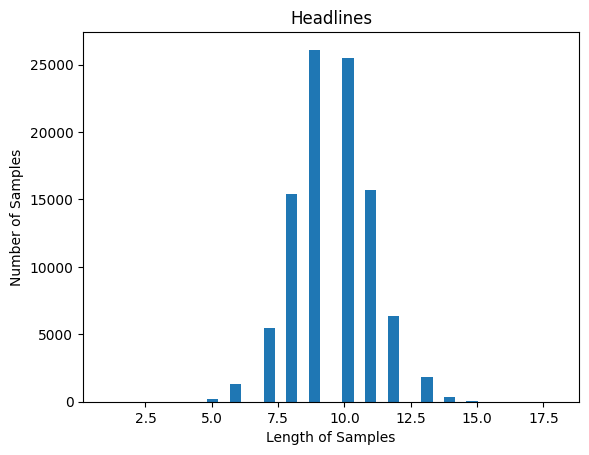

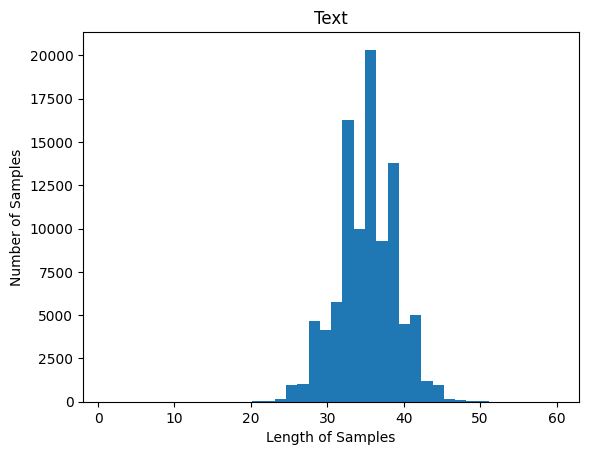

In [16]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이: {}'.format(np.min(text_len)))
print('텍스트의 최대 길이: {}'.format(np.max(text_len)))
print('텍스트의 평균 길이: {}'.format(np.mean(text_len)))
print('요약의 최소 길이: {}'.format(np.min(headlines_len)))
print('요약의 최대 길이: {}'.format(np.max(headlines_len)))
print('요약의 평균 길이: {}'.format(np.mean(headlines_len)))

plt.subplot(1, 2, 1)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1, 2, 2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins=40)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

이로부터 text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해보자.

In [17]:
# 최대 길이 지정
text_max_len = 40
headlines_max_len = 12

이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 된다.

In [18]:
# 데이터의 몇 %가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9768198454656364


정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제하도록 하자.

In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88714


#### **시작 토큰과 종료 토큰 추가하기**

In [21]:
# 요약 데이터에 시작 토큰과 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,healines,decoder_input,decoder_target
2,New Zealand end Rohit Sharma-led India's 12-ma...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
7,Govt directs Alok Verma to join work 1 day bef...,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken Govt directs Alok Verma to join work ...,Govt directs Alok Verma to join work 1 day bef...
8,Called PM Modi 'sir' 10 times to satisfy his e...,andhra pradesh cm chandrababu naidu said met u...,called pm modi sir times to satisfy his ego an...,sostoken Called PM Modi 'sir' 10 times to sati...,Called PM Modi 'sir' 10 times to satisfy his e...


In [22]:
# Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### **훈련 데이터와 테스트 데이터 분리하기**

In [23]:
# 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
indices

array([46704, 17548, 13788, ..., 73054, 48659, 58649])

In [24]:
# 데이터의 샘플 순서 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
# 테스트 데이터의 크기 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17742


In [26]:
# 전체 데이터 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 70972
훈련 레이블의 개수 : 70972
테스트 데이터의 개수 : 17742
테스트 레이블의 개수 : 17742


훈련 데이터와 테스트 데이터가 잘 분리된 것을 볼 수 있다.

#### **단어 집합(vocabulary) 만들기 및 정수 인코딩**

In [27]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하기로 한다.

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65382
등장 빈도가 6번 이하인 희귀 단어의 수: 44554
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20828
단어 집합에서 희귀 단어의 비율: 68.14413753020709
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.6905181501026383


등장 빈도로 차지하는 비중은 상대적으로 적은 수치이기 때문에 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다.

In [29]:
src_vocab = 20000 # 희귀 단어를 제외한 단어 집합의 크기
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[153, 244, 1888, 681, 4634, 959, 75, 1993, 509, 327, 341, 171, 12, 4092, 12, 2414, 3971, 509, 327, 570, 171, 275, 673, 12, 193, 261, 12, 562, 2099, 36, 1, 467], [67, 348, 755, 26, 881, 3591, 177, 8512, 1742, 2199, 94, 8, 10740, 346, 43, 518, 1393, 1054, 8, 1, 1840, 755, 6, 346, 10740, 346, 169, 913, 744, 1637, 3911, 8, 2284, 4218, 2465, 182, 3390, 1155, 79, 1], [1072, 188, 10, 52, 2595, 2910, 453, 14974, 789, 566, 1147, 1072, 2134, 453, 20, 719, 566, 751, 1528, 5944, 2864, 1246, 164, 3101, 51, 101, 87, 1750, 1299, 350, 14975]]


headlines 데이터에도 동일한 작업을 수행하자.

In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 38768
등장 빈도가 5번 이하인 희귀 단어의 수: 28084
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10684
단어 집합에서 희귀 단어의 비율: 72.4411886091622
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.542221592519128


In [33]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input',decoder_input_train[:5])
print('target')
print('decoder',decoder_target_train[:5])

input
input [[1, 2710, 454, 628, 877, 1646, 589, 4448, 80], [1, 5510, 796, 553, 4, 28, 4449, 289, 1296, 1093], [1, 47, 37, 3099, 482, 4, 283, 1359], [1, 309, 2040, 120, 7656, 4134, 8, 1305, 4, 2558], [1, 48, 636, 3, 532, 1135, 1607, 130]]
target
decoder [[2710, 454, 628, 877, 1646, 589, 4448, 80, 2], [5510, 796, 553, 4, 28, 4449, 289, 1296, 1093, 2], [47, 37, 3099, 482, 4, 283, 1359, 2], [309, 2040, 120, 7656, 4134, 8, 1305, 4, 2558, 2], [48, 636, 3, 532, 1135, 1607, 130, 2]]


정수 인코딩 작업 후, 빈도수가 낮은 단어가 삭제되어 빈(empty) 샘플이 발생할 수 있다.  
따라서 길이가 0인 요약문의 인덱스를 삭제해야 하는데, sostoken과 eostoken과 같은 토큰은 삭제되지 않으므로 실제 길이는 1이 된다.

In [34]:
# 길이가 1인 인덱스 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 70972
훈련 레이블의 개수 : 70972
테스트 데이터의 개수 : 17741
테스트 레이블의 개수 : 17741


훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인할 수 있다.

#### **패딩하기**

최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰주자.

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### **Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)**

#### **모델 설계하기**

In [ ]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

#### **모델 훈련하기**

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### **Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)**

#### **인퍼런스 모델 구현하기**
테스트 단계에서 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원하기 위해 3개의 사전을 준비해야 한다.

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

훈련 단계에서는 인코더와 디코더를 엮은 통짜 모델 하나만 준비했었다.  
하지만 정답 문장이 없는 인퍼런스 단계에서는 인코더 모델과 디코더 모델을 분리해서 설계해야 한다.

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
# 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트
        e_h, e_c = h, c

    return decoded_sentence

#### **모델 테스트하기**

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

### **Step 5. Summa을 이용해서 추출적 요약해보기**

---